In [21]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
tf.config.run_functions_eagerly(True)

In [22]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk',"2017-09-28","2021-09-24")
data.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [23]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MTM6']=talib.MOM(data['Close'],timeperiod=6)
data['MTM12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Predictions']=data['Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_23129/3539161405.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop('Adj Close',1,inplace=True)


,Open,High,Low,Close,Volume,6day MA,12day MA,RSI,%R5,%R10,MTM6,MTM12,EMA12,EMA26,MACD,TR,OSC6,OSC12,Predictions
Date,,,,,,,,,,,,,,,,,,,
2017-09-28,76.400002,77.099998,76.050003,76.199997,22520013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.550003
2017-09-29,76.500000,76.900002,76.300003,76.550003,16766252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.700005,NaN,NaN,77.449997
2017-10-03,76.800003,77.449997,76.699997,77.449997,24369212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.899994,NaN,NaN,77.849998
2017-10-04,77.500000,77.949997,77.500000,77.849998,21197563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,77.349998
2017-10-06,77.599998,77.800003,77.199997,77.349998,23715110,NaN,NaN,NaN,-31.578969,NaN,NaN,NaN,NaN,NaN,NaN,0.650002,NaN,NaN,77.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,40.599998,40.599998,39.599998,40.000000,19553563,40.383334,40.812500,24.116608,-73.333232,-81.818119,-0.450001,-1.450001,40.769304,41.557317,-0.788012,1.000000,-53.994971,-43.078452,40.250000
2021-09-17,39.700001,40.400002,39.099998,40.250000,28266370,40.358334,40.683334,34.315393,-42.499924,-55.769211,-0.150002,-1.549999,40.689411,41.460478,-0.771067,1.300003,-29.212280,-32.890221,39.000000
2021-09-20,39.900002,39.950001,38.950001,39.000000,23796781,40.041667,40.487501,19.235038,-97.674452,-97.959215,-1.900002,-2.349998,40.429502,41.278221,-0.848719,1.299999,-63.986545,-51.664066,38.799999


In [24]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', 'RSI',
       '%R5', '%R10', 'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC6',
       'OSC12', 'Predictions'],
      dtype='object')

In [25]:
data.dropna(inplace=True,axis=0)
data.isnull().sum()

Open           0
High           0
Low            0
Close          0
Volume         0
6day MA        0
12day MA       0
RSI            0
%R5            0
%R10           0
MTM6           0
MTM12          0
EMA12          0
EMA26          0
MACD           0
TR             0
OSC6           0
OSC12          0
Predictions    0
dtype: int64

In [26]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, target):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = target[TIME_STEPS+i]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols =[ 'Open', 'High', 'Low', 'Close', 'Volume', '6day MA', '12day MA', 'RSI',
       '%R5', '%R10', 'MTM6', 'MTM12', 'EMA12', 'EMA26', 'MACD', 'TR', 'OSC6','OSC12']
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 100,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
y = df_train.loc[:,["Close"]].values
min_max_scaler = MinMaxScaler()
min_max_scaler_y = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
y=min_max_scaler_y.fit_transform(y)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
y_test = min_max_scaler_y.fit_transform(df_test.loc[:,["Predictions"]])
# y_test=min_max_scaler_y.fit_transform(y_test)
x_t, y_t = build_timeseries(x_train, y)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
# print(x_test.shape)
print("Batch trimmed size", x_t.shape, y_t.shape)

Train--Test size 759 190
Length of inputs 749
length of time-series - inputs (749, 10, 18)
length of time-series - outputs (749,)
Batch trimmed size (740, 10, 18) (740,)


/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [27]:
'''Step 9 - Construct customized loss function for training'''
def custom_loss(y_true, y_pred):
    
    #extract the "next day's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "today's price" of tensor
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    print('Shape of y_pred_back -', y_pred_tdy.get_shape())
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    indices = tf.where(condition)

    #move one position later
    ones = tf.ones_like(indices)
    indices = tf.add(indices, ones)
    indices = K.cast(indices, dtype='int32')
    
    
    #create a tensor to store directional loss and put it into custom loss output
    direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
    updates = K.cast(tf.ones_like(indices), dtype='float32')
    alpha = 1000
    direction_loss = tf.compat.v1.scatter_nd_update(direction_loss, indices, alpha*updates)
    
    custom_loss = K.mean(tf.multiply(K.square(y_true - y_pred), direction_loss), axis=-1)
    
    return custom_loss

In [28]:
'''Step 10 - Build LSTM model'''

def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(128, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform',
                        recurrent_regularizer='l2'))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(64, dropout=0.0))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(64))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(32))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss=custom_loss, optimizer=optimizer)
  
    return lstm_model

lstm_model = None

In [29]:
# lstm_model = Sequential()
#     # (batch_size, timesteps, data_dim)
# lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
#                     dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
#                     kernel_initializer='random_uniform'))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(LSTM(60, dropout=0.0))
# # lstm_model.add(Dropout(0.4))
# lstm_model.add(Dense(20,activation='relu'))
# lstm_model.add(Dense(1,activation='sigmoid'))
# optimizer = RMSprop(learning_rate=params["lr"])
# # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
# lstm_model.compile(loss=custom_loss, optimizer=optimizer)

In [30]:
x_temp, y_temp = build_timeseries(x_test,y_test)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

Length of inputs 180
length of time-series - inputs (180, 10, 18)
length of time-series - outputs (180,)


In [31]:
lstm_model = create_lstm_model()
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (20, 10, 128)             75264     
                                                                 
 dropout_4 (Dropout)         (20, 10, 128)             0         
                                                                 
 lstm_3 (LSTM)               (20, 64)                  49408     
                                                                 
 dropout_5 (Dropout)         (20, 64)                  0         
                                                                 
 dense_3 (Dense)             (20, 64)                  4160      
                                                                 
 dropout_6 (Dropout)         (20, 64)                  0         
                                                                 
 dense_4 (Dense)             (20, 32)                 

/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(x_t, y_t, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)),callbacks=[es])

/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100
Shape of y_pred_back - (19, 1)
 2/37 [>.............................] - ETA: 2s - loss: 288.4005Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
 4/37 [==>...........................] - ETA: 1s - loss: 329.1975Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
 6/37 [===>..........................] - ETA: 1s - loss: 332.6437Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
 8/37 [=====>........................] - ETA: 1s - loss: 332.2114Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
10/37 [=======>......................] - ETA: 1s - loss: 304.6230Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
12/37 [========>.....................] - ETA: 1s - loss: 281.2415Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
14/37 [==========>...................] - ETA: 0s - loss: 257.7726Shape of y_pred_back - (19, 1)
Shape of y_pred_back - (19, 1)
16/37 [===========>..................] - ETA: 0s - loss: 237.6139Sha

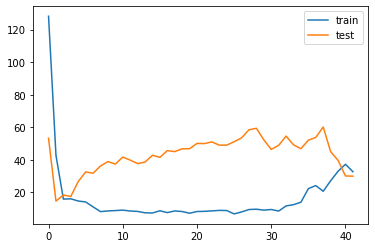

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [34]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = min_max_scaler_y.inverse_transform(y_pred.reshape(-1,1))
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = min_max_scaler_y.inverse_transform(y_test_t.reshape(-1,1))
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

Error is 0.06697080412612391 (80,) (80,)
[0.3834884  0.38316542 0.38496327 0.3870741  0.3863972  0.3848263
 0.38410455 0.38429603 0.3864249  0.38727048 0.39237148 0.39008176
 0.388982   0.38674182 0.38530093]
[0.8125     0.86666679 0.80416679 0.8125     0.84166686 0.86666679
 0.85833327 0.84583346 1.         0.875      0.91250006 0.86250019
 0.83333333 0.8125     0.82500013]
[[43.401863]
 [43.397984]
 [43.41956 ]
 [43.44489 ]
 [43.436768]
 [43.417915]
 [43.409256]
 [43.411552]
 [43.437096]
 [43.447247]
 [43.508457]
 [43.48098 ]
 [43.46778 ]
 [43.4409  ]
 [43.42361 ]]
[[48.54999924]
 [49.20000076]
 [48.45000076]
 [48.54999924]
 [48.90000153]
 [49.20000076]
 [49.09999847]
 [48.95000076]
 [50.79999924]
 [49.29999924]
 [49.75      ]
 [49.15000153]
 [48.79999924]
 [48.54999924]
 [48.70000076]]


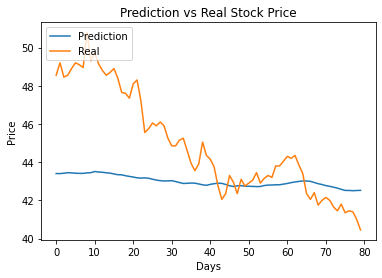

In [35]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

In [36]:
mean_absolute_percentage_error(y_pred_org,y_test_t_org)*100

5.466129667105964

In [37]:
mean_squared_error(y_pred_org,y_test_t_org)

9.643795733539616

In [38]:
from sklearn.metrics import accuracy_score
y_pred_lstm_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

y_test_t_final = np.zeros((len(y_test_t_org)-1,))
y_pred_lstm_final = np.zeros((len(y_pred)-1,))

#convert prediction into binary output (up or down movement)
for i in range(len(y_pred_lstm_org)-1):
    if y_pred_lstm_org[i+1] >= y_pred_lstm_org[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t_org)-1):
    if y_test_t_org[i+1] >= y_test_t_org[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[50.308105 50.289486 50.393135 50.514824 50.4758   50.38524  50.343628
 50.354668 50.477394 50.526142 50.820213 50.688213 50.62481  50.495667
 50.412598]
[75.0406239  78.16333944 74.56021459 75.0406239  76.72209317 78.16333944
 77.6829118  76.96229782 85.84999847 78.64374876 80.80562734 77.92313478
 76.24166552 75.0406239  75.76125621]
[0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
[1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.]
Predicted direction accuracy (Up/down):
0.4430379746835443
